# Knowledge Distillation
- The concept of **knowledge distillation** is to utilize class probabilities of a higher-capacity model (teacher) as soft targets of a smaller model (student)
- The implement processes can be divided into several stages:
  1. Finish the `ResNet()` classes
  2. Train the teacher model (ResNet34) from scratch
  3. Train the student model (ResNet18) from scratch, i.e. **without KD**
  4. Define the `Distiller()` class and `loss_re()`, `loss_fe()` functions
  5. Train the student model **with KD** from the teacher model in two different ways, response-based and feature based distillation
  6. Comparison of student models w/ & w/o KD
- Requirements
  1. Response-based distillation (35%)
    - accuracy≥0.8 got 30%, the more improvement the higher score compare with student from scratch
  2. Feature-based distillation (35%)
    - same as above
  3. Report (30%)
    - Comparison of student models w/ & w/o KD
    - How you choose the **Temperature** and **alpha** in response-based KD
    - How you extracte features from the choosing intermediate layers
    - How you design the loss of your response-based and feature-based KD
    - Any problems you met & how you solved them

# Setup

In [1]:
from PIL import Image

def is_grayscale(img_path):
    with Image.open(img_path) as img:
        if img.mode == 'L':
            return True  # 灰階
        elif img.mode == 'RGB':
            return False  # 彩色
        else:
            return False  # 其他模式，通常不是灰階

img_path = './UTK+Facial_Aug/1_1.jpg'
if is_grayscale(img_path):
    print("這是一張灰階圖片")
else:
    print("這是一張彩色圖片")

這是一張彩色圖片


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive

In [4]:
!pip install torchinfo
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split,Dataset,Subset
from torchinfo import summary
from tqdm import tqdm
import sys
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import os
import re

In [5]:
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# UTKFace dataset

In [6]:
# # Define a custom dataset class
# class UTKFaceDataset(Dataset):
#     def __init__(self, data_dir, transform):
#         self.data_dir = data_dir
#         self.image_files = os.listdir(data_dir)
#         self.transform = transform
#         self.age_to_index = {1:0, 2:1, 3:2, 4:3, 5:4,6:5,7:6}

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.data_dir, self.image_files[idx])
#         # image = Image.open(img_path).convert('L')

#         if self.transform:
#             image = self.transform(image)

#         # Extract age from the filename using regular expression
#         age = int(re.search(r'\d+', os.path.basename(img_path)).group())
#         age_index = self.age_to_index[age]

#         return image, age_index

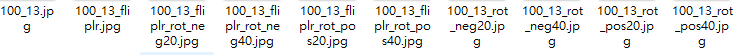

In [7]:
class UTKFaceDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.image_files = os.listdir(data_dir)
        self.transform = transform
        self.age_to_index = {(1,2):0, (3,9):1, (10,20):2, (21,27):3, (28,45):4, (46,65):5, (66,116):6}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        # Extract age from the filename
        age = int(re.search(r'\d+', os.path.basename(img_path)).group())

        # Find the age range that the extracted age falls into
        age_index = None
        for range, index in self.age_to_index.items():
            if range[0] <= age <= range[1]:
                age_index = index
                break

        # Ensure age_index is not None
        if age_index is None:
            raise ValueError(f"Age {age} not in defined ranges")

        return image, age_index

In [8]:
# Define the data transformation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomCrop(110),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5,], std=[0.5,])
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.5,], std=[0.5,])
])


# Create the dataset
# data_dir = '/content/drive/MyDrive/UTKFace_rename'
data_dir = './UTK+Facial_Aug'
train_dataset_with_transform = UTKFaceDataset(data_dir, transform=train_transform)
val_dataset_with_transform = UTKFaceDataset(data_dir, transform=val_test_transform)
test_dataset_with_transform = UTKFaceDataset(data_dir, transform=val_test_transform)


# split train, test and validation dataset
total_size = len(train_dataset_with_transform)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_subset, val_subset, test_subset = random_split(train_dataset_with_transform, [train_size, val_size, test_size])

train_dataset = Subset(train_dataset_with_transform, train_subset.indices)
val_dataset = Subset(val_dataset_with_transform, val_subset.indices)
test_dataset = Subset(test_dataset_with_transform, test_subset.indices)



# create dataLoader
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


test_num = len(test_dataset)
test_steps = len(test_loader)

# Create teacher and student models


## Create Resnet structure

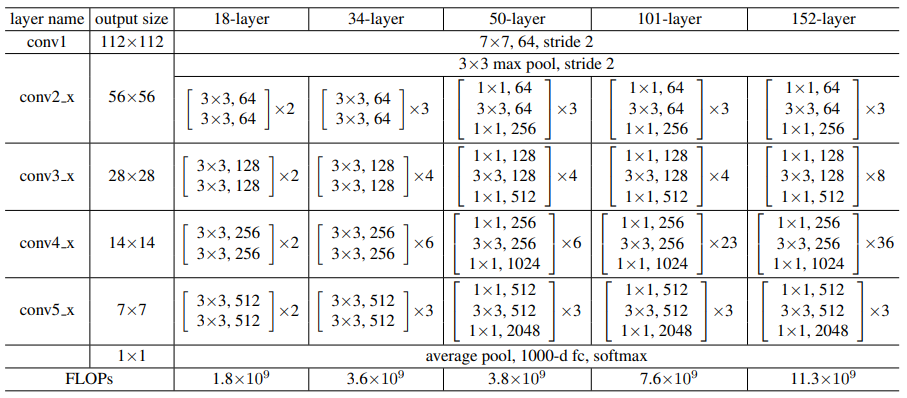

- Please finish the rest part of ResNet structure

In [9]:
# get BasicBlock which layers < 50(18, 34)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample #Residual Block結構的輸入與輸出通道數量不一致，這時候我們就需要在短路連接的時候調整通道數量

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [10]:
# get BottleBlock which layers >= 50
class Bottleneck(nn.Module):
    expansion = 4 # the factor of the last layer of BottleBlock and the first layer of it
 
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*4, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*4)
        self.downsample = downsample
        self.relu = nn.ReLU()
 

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

In [11]:
class ResNet(nn.Module):

    def __init__(self, block, blocks_num, num_classes=7):
        super(ResNet, self).__init__()
        self.in_channel = 8

        self.conv1 = nn.Conv2d(1, self.in_channel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel, channel, downsample=downsample, stride=stride))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel, channel))

        return nn.Sequential(*layers)

    def forward(self, x):
        ######################################################################################################
        # 1. Finish the forward pass and return the output layer as well as hidden features.  #
        # 2. The output layer and hidden features will be used later for distilling.       #
        # 3. You can refer to the ResNet structure illustration to finish it.           #
        ####################################################################################################


        # Initial convolution and batch normalization
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # First set of ResNet blocks
        feature1 = self.layer1(x)

        # Second set of ResNet blocks
        feature2 = self.layer2(feature1)

        # Third set of ResNet blocks
        feature3 = self.layer3(feature2)

        # Fourth set of ResNet blocks
        feature4 = self.layer4(feature3)

        # Global Average Pooling
        out = self.avgpool(feature4)
        out = out.view(out.size(0), -1) # Flatten the tensor

        # Fully connected layer for classification
        out = self.fc(out)

        return out, [feature1, feature2, feature3, feature4]

def resnet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet50(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)


def resnet101(num_classes=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)

def resnet152(num_classes=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)   

## Teacher model

In [12]:
Teacher_18 = resnet18(num_classes=7)
Teacher_18 = Teacher_18.to(device)

Teacher_34 = resnet34(num_classes=7)
Teacher_34 = Teacher_34.to(device)

Teacher_50 = resnet50(num_classes=7)
Teacher_50 = Teacher_50.to(device)

Teacher_101 = resnet101(num_classes=7)
Teacher_181 = Teacher_101.to(device)

Teacher_152 = resnet152(num_classes=7)
Teacher_152 = Teacher_152.to(device)


In [13]:
# summary(Teacher)

## Student model

In [14]:
Student = resnet18(num_classes=7)  # commment out this line if loading trained student model
# Student = torch.load('Student.pt')  # loading trained student model
Student = Student.to(device)

In [15]:
summary(Student)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            72
├─BatchNorm2d: 1-2                       16
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  4,608
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    │    └─Sequential: 3-6              640
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-7                  36,864
│    │    └─BatchNorm2d: 3-8             128
│    │    └─ReLU: 3-9                    --
│    │    └─Conv2d: 3-10                 36,864
│    │    └─BatchNorm2d: 3-11            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │ 

# Define training and testing function

In [16]:
def plot_errors(train_error, val_error):
    plt.figure(figsize=(10, 5))
    plt.plot(train_error, label='Training Loss')
    plt.plot(val_error, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_acc(train_acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training acc')
    plt.plot(val_acc, label='Validation acc')
    plt.title('Training and Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('acc')
    plt.legend()
    plt.show()



In [17]:

def train_from_scratch(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    loss = []
    train_error=[]
    val_error = []
    valdation_error = []
    train_loss = []
    valdation_loss = []
    train_accuraacy = []
    valdation_accuracy= []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0
        correct = 0.
        total = 0.
        V_correct = 0.
        V_total = 0.

        model.train()
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, hidden = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)
            pred = logits.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(labels.data.view_as(pred))).cpu().numpy())
            total += images.size(0)
            train_acc =  correct/total
            train_bar.desc = "train epoch[{}/{}]".format(epoch + 1, epochs)

        model.eval()
        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs, hidden_outputs = model(val_images)
                loss = criterion(outputs, val_labels)
                valid_loss += loss.item() * val_images.size(0)
                pred = outputs.data.max(1, keepdim=True)[1]
                V_correct += np.sum(np.squeeze(pred.eq(val_labels.data.view_as(pred))).cpu().numpy())
                V_total += val_images.size(0)
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

        train_loss = train_loss / len(train_loader.dataset)
        train_error.append(train_loss)
        valid_loss = valid_loss / len(val_loader.dataset)
        val_error.append(valid_loss)
        train_accuraacy.append( correct / total)
        valdation_accuracy.append(V_correct / V_total)

        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('\tTrain Accuracy: %.3fd%% (%2d/%2d)\tValdation Accuracy: %.3fd%% (%2d/%2d) '% (100. * correct / total, correct, total, 100. * V_correct / V_total, V_correct, V_total))

    # torch.save(model, f'{model.__class__.__name__}.pt')
    print('Finished Training')
    # 調用畫圖函數
    plot_errors(train_error, val_error)
    plot_acc(train_accuraacy,valdation_accuracy)

In [18]:
def test(model, test_loader ,device, type=None):
    criterion = nn.CrossEntropyLoss()
    acc = 0.0
    test_loss = 0.0

    if type == None:
        model.eval()
    elif type == 'distiller':
        model.eval()
        model.teacher.eval()
        model.student.eval()
    else:
       raise ValueError(f'Error: only support response-based and feature-based distillation')

    with torch.no_grad():
        test_bar = tqdm(test_loader, file=sys.stdout)

        for test_data in test_bar:
            test_images, test_labels = test_data
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            if type == None:
                outputs, features = model(test_images)
                loss = criterion(outputs, test_labels)
            elif type == 'distiller':
                outputs, loss = model(test_images, test_labels)
            else:
                raise ValueError(f'Error: only support response-based and feature-based distillation')

            predict_y = torch.max(outputs, dim=1)[1]
            acc += torch.eq(predict_y, test_labels.to(device)).sum().item()
            test_loss += loss.item()
            test_bar.desc = "test"

    test_accurate = acc / test_num
    print('test_loss: %.3f  test_accuracy: %.3f' %(test_loss / test_steps, test_accurate * 100))
    return test_loss / test_steps, test_accurate * 100.

# Define distillation fuction

In [19]:
#####################################################################
# Finish the loss function for response-based distillation. #
#####################################################################
def loss_re(student_logits, teacher_logits, labels):
    T = 5 #!!!!!!!!!!!!!!!!!!
    alpha = 0.3 #!!!!!!!!!!!!!!!!!

    # 1.蒸餾損失:
    distillation_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction='batchmean'
    ) * (T**2)

    # 2.標準損失 :
    standard_loss = F.cross_entropy(student_logits, labels)

    loss = alpha * standard_loss + (1 - alpha) * distillation_loss
    return loss

In [20]:
####################################################################
# Finish the loss function for feature-based distillation. #
####################################################################
def loss_fe(student_features, teacher_features, student_logits, labels):
    criterion = F.mse_loss
    feature_weights = [1.0, 1.0, 1.0, 1.0]
    loss = 0.0
    assert len(student_features) == len(teacher_features) == len(feature_weights)

    for s_feature, t_feature, weight in zip(student_features, teacher_features, feature_weights):
      layer_loss = criterion(s_feature, t_feature)
      loss += layer_loss * weight

    standard_loss = F.cross_entropy(student_logits, labels)
    loss +=  standard_loss

    return loss

In [21]:
class Distiller(nn.Module):
    def __init__(self, teacher, student, type):
        super(Distiller, self).__init__()

        ########################################
        # 1. Finish the __init__ method. #
        ########################################
        self.teacher = teacher
        self.student = student
        self.type = type

    def forward(self, x, target):

        #####################################
        # 2. Finish the forward pass. #
        #####################################

        with torch.no_grad():
          teacher_logits,teacher_feature = self.teacher(x)

        student_logits,student_feature = self.student(x)

        if self.type == 'response':
            loss_distill = loss_re(student_logits, teacher_logits, target)

        elif self.type == 'feature':
            loss_distill = loss_fe(student_feature, teacher_feature, student_logits, target)

        else:
            raise ValueError(f'Error: only support response-based and feature-based distillation')

        return student_logits, loss_distill

In [31]:
def train_distillation(distiller, student, train_loader, val_loader, epochs, learning_rate, device):
    ce_loss = nn.CrossEntropyLoss()
    ###########################
    # define the optimizer #
    ###########################
    params = [p for p in distiller.student.parameters() if p.requires_grad] #!!!!!!!!!!!!!!!!!!!!
    optimizer = torch.optim.Adam(params, lr=learning_rate) #!!!!!!!!!!!!!!!!!!!!


    loss = []
    train_error=[]
    val_error = []
    valdation_error = []
    train_loss = []
    valdation_loss = []
    train_accuraacy = []
    valdation_accuracy= []

    for epoch in range(epochs):
        distiller.train()
        distiller.teacher.train()
        distiller.student.train()

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc  = 0.0
        correct = 0.
        total = 0.
        V_correct = 0.
        V_total = 0.
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs, loss = distiller(images, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            pred = outputs
            pred = pred.data.max(1, keepdim=True)[1]
            result = pred.eq(labels.data.view_as(pred))
            result = np.squeeze(result.cpu().numpy())
            correct += np.sum(result)
            total += images.size(0)
            train_bar.desc = "train epoch[{}/{}]".format(epoch + 1, epochs)

        distiller.eval()
        distiller.teacher.eval()
        distiller.student.eval()

        with torch.no_grad():
            val_bar = tqdm(val_loader, file=sys.stdout)
            for val_data in val_bar:

                val_images, val_labels = val_data
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                outputs, loss = distiller(val_images, val_labels)

                valid_loss += loss.item() * val_images.size(0)
                pred = outputs.max(1, keepdim=True)[1]
                V_correct += np.sum(np.squeeze(pred.eq(val_labels.data.view_as(pred))).cpu().numpy())
                V_total += val_images.size(0)
                val_bar.desc = "valid epoch[{}/{}]".format(epoch + 1, epochs)

        train_loss = train_loss / len(train_loader.dataset)
        train_error.append(train_loss)
        valid_loss = valid_loss / len(val_loader.dataset)
        val_error.append(valid_loss)
        train_accuraacy.append( correct / total)
        valdation_accuracy.append(V_correct / V_total)

        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('\tTrain Accuracy: %.3fd%% (%2d/%2d)\tValdation Accuracy: %.3fd%% (%2d/%2d) '% (100. * correct / total, correct, total, 100. * V_correct / V_total, V_correct, V_total))

    print('Finished Distilling')
    plot_errors(train_error, val_error)
    plot_acc(train_accuraacy,valdation_accuracy)

# Train Teacher and Student model from scratch

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:01<00:00, 17.73it/s]
	Training Loss: 0.810991 	Validation Loss: 0.798961
	Train Accuracy: 64.899d% (106486/164080)	Valdation Accuracy: 66.067d% (23229/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:04<00:00, 16.96it/s]
	Training Loss: 0.740206 	Validation Loss: 0.704019
	Train Accuracy: 68.204d% (111909/164080)	Valdation Accuracy: 70.011d% (24616/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:04<00:00, 17.06it/s]
	Training Loss: 0.676336 	Validation Loss: 0.657270
	Train Accuracy: 71.050d% (116579/164080)	Valdation Accuracy: 71.664d% (25197/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:03<00:00, 17.36it/s]
	Training Loss: 0.615882 	Validation Loss: 0.582308
	Train Accuracy: 73.785d% (121066/164080)	Valdation Ac

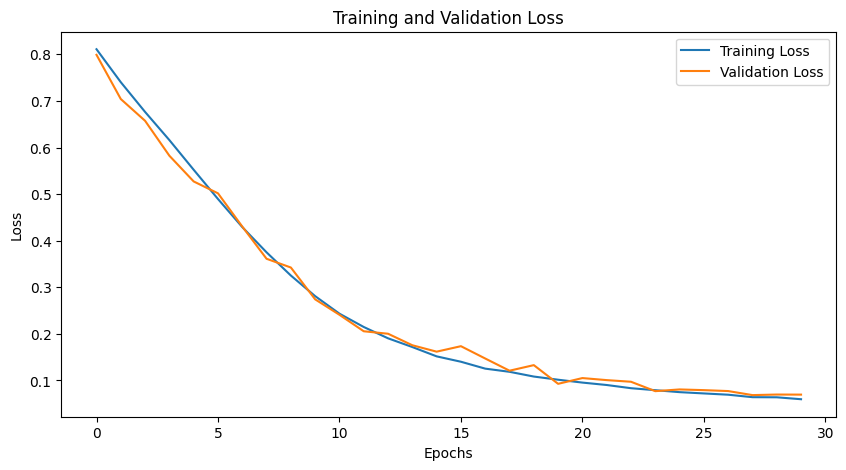

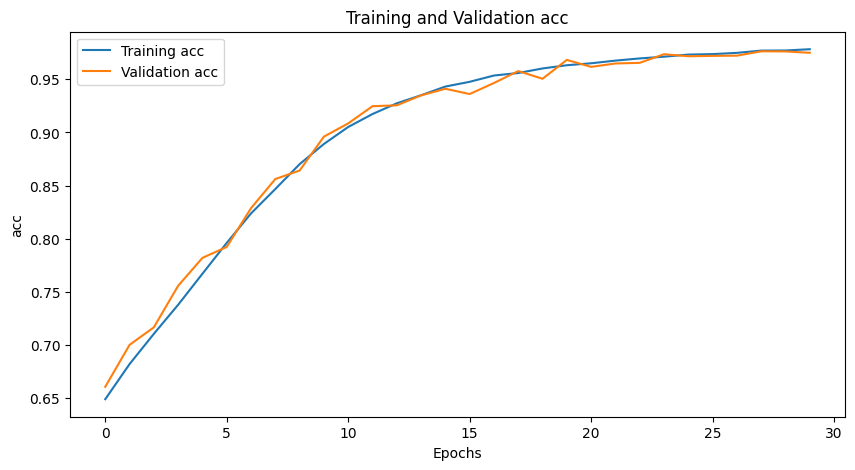

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:04<00:00, 17.13it/s]
test_loss: 0.069  test_accuracy: 97.500


In [27]:
#############################################
# Decide the epochs and learning rate #
#############################################
torch.cuda.empty_cache()
train_from_scratch(Teacher_18, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)
torch.save(Teacher_18.state_dict(), 'utk_teacher_model_18.pth')
T_loss, T_accuracy = test(Teacher_18, test_loader, device=device)

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:02<00:00, 17.55it/s]
	Training Loss: 1.203985 	Validation Loss: 1.011786
	Train Accuracy: 49.161d% (80664/164080)	Valdation Accuracy: 57.108d% (20079/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [00:55<00:00, 19.68it/s]
	Training Loss: 0.945825 	Validation Loss: 0.903441
	Train Accuracy: 59.467d% (97574/164080)	Valdation Accuracy: 61.655d% (21678/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:02<00:00, 17.58it/s]
	Training Loss: 0.841952 	Validation Loss: 0.788092
	Train Accuracy: 63.772d% (104637/164080)	Valdation Accuracy: 66.547d% (23398/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [00:57<00:00, 19.26it/s]
	Training Loss: 0.772995 	Validation Loss: 0.734048
	Train Accuracy: 66.680d% (109408/164080)	Valdation Accu

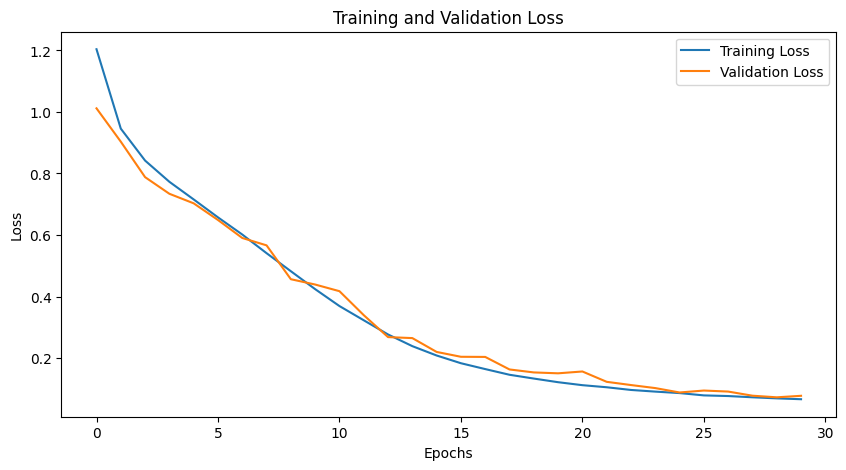

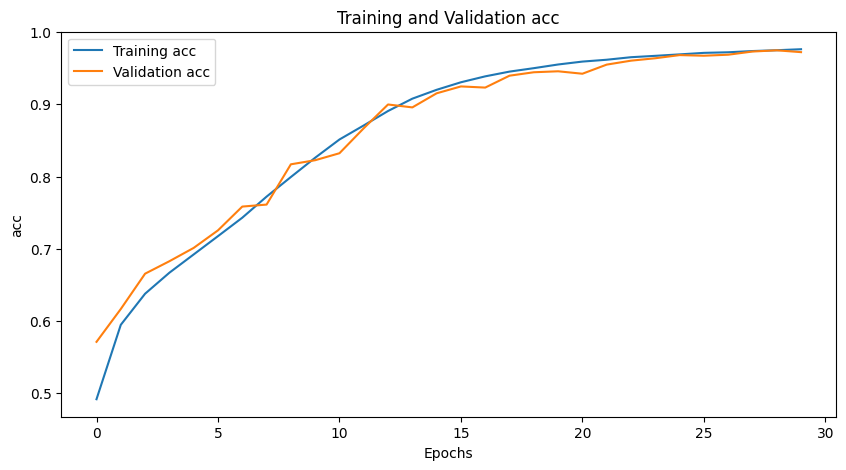

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:03<00:00, 17.21it/s]
test_loss: 0.074  test_accuracy: 97.494


In [24]:
#############################################
# Decide the epochs and learning rate #
#############################################
torch.cuda.empty_cache()
train_from_scratch(Teacher_34, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)
torch.save(Teacher_34.state_dict(), 'utk_teacher_model_34.pth')
T_loss, T_accuracy = test(Teacher_34, test_loader, device=device)

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:16<00:00, 14.46it/s]
	Training Loss: 1.213586 	Validation Loss: 1.122785
	Train Accuracy: 49.539d% (81283/164080)	Valdation Accuracy: 52.722d% (18537/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:11<00:00, 15.36it/s]
	Training Loss: 0.980627 	Validation Loss: 0.960850
	Train Accuracy: 58.264d% (95600/164080)	Valdation Accuracy: 57.682d% (20281/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:16<00:00, 14.39it/s]
	Training Loss: 0.882013 	Validation Loss: 0.834768
	Train Accuracy: 62.078d% (101858/164080)	Valdation Accuracy: 64.303d% (22609/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:12<00:00, 15.08it/s]
	Training Loss: 0.819230 	Validation Loss: 0.788392
	Train Accuracy: 64.688d% (106140/164080)	Valdation Accu

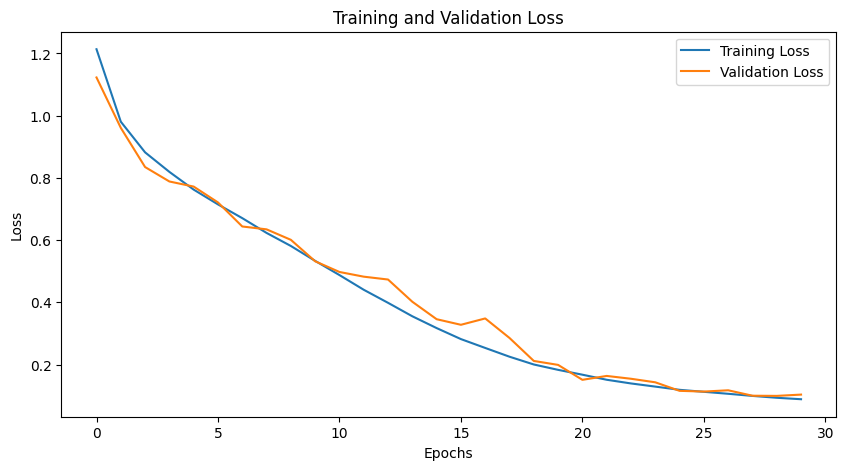

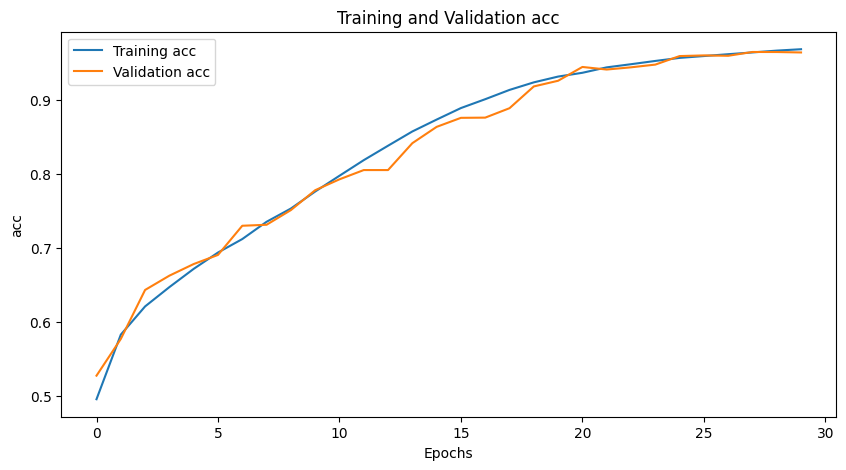

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:16<00:00, 14.35it/s]
test_loss: 0.100  test_accuracy: 96.496


In [25]:
#############################################
# Decide the epochs and learning rate #
#############################################
torch.cuda.empty_cache()
train_from_scratch(Teacher_50, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)
torch.save(Teacher_50.state_dict(), 'utk_teacher_model_50.pth')
T_loss, T_accuracy = test(Teacher_50, test_loader, device=device)

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:35<00:00, 11.56it/s]
	Training Loss: 1.286651 	Validation Loss: 1.260087
	Train Accuracy: 46.332d% (76021/164080)	Valdation Accuracy: 50.438d% (17734/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:34<00:00, 11.64it/s]
	Training Loss: 1.028131 	Validation Loss: 0.913510
	Train Accuracy: 56.066d% (91993/164080)	Valdation Accuracy: 61.377d% (21580/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:33<00:00, 11.72it/s]
	Training Loss: 0.920381 	Validation Loss: 0.940214
	Train Accuracy: 60.464d% (99209/164080)	Valdation Accuracy: 59.303d% (20851/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:33<00:00, 11.79it/s]
	Training Loss: 0.846869 	Validation Loss: 0.836636
	Train Accuracy: 63.446d% (104103/164080)	Valdation Accur

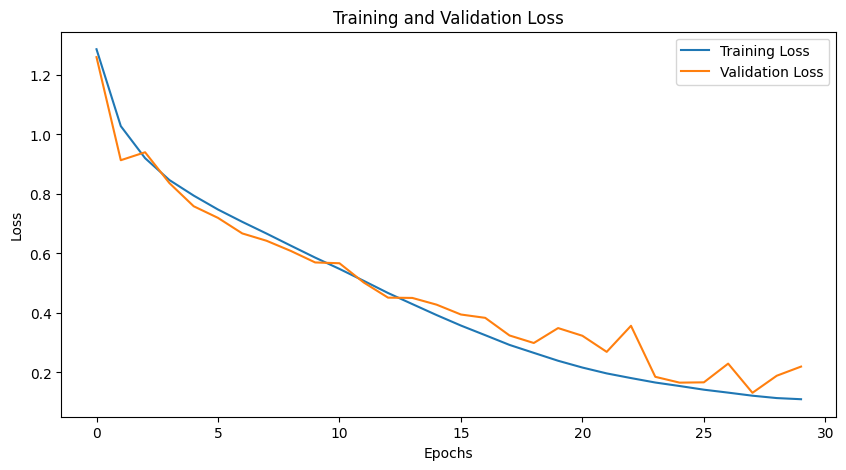

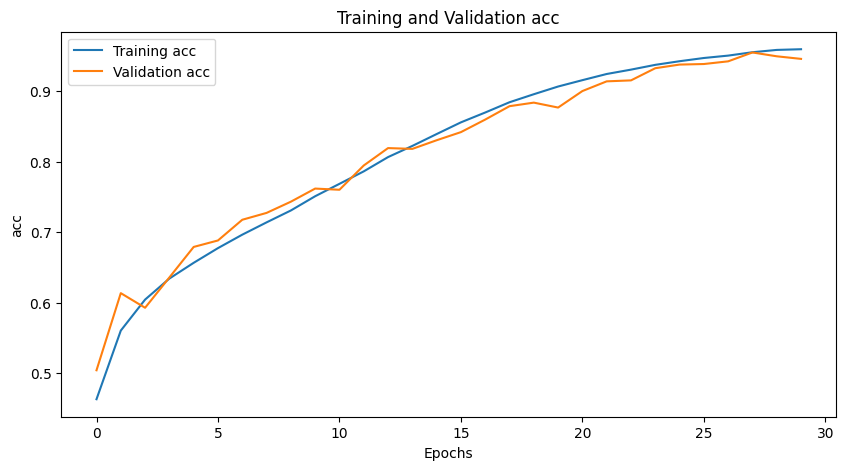

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:38<00:00, 11.19it/s]
test_loss: 0.206  test_accuracy: 94.878


In [26]:
#############################################
# Decide the epochs and learning rate #
#############################################
torch.cuda.empty_cache()
train_from_scratch(Teacher_101, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)
torch.save(Teacher_101.state_dict(), 'utk_teacher_model_101.pth')
T_loss, T_accuracy = test(Teacher_101, test_loader, device=device)

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:57<00:00,  9.35it/s]
	Training Loss: 1.288983 	Validation Loss: 1.157933
	Train Accuracy: 46.112d% (75661/164080)	Valdation Accuracy: 51.763d% (18200/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:55<00:00,  9.49it/s]
	Training Loss: 1.028047 	Validation Loss: 1.087812
	Train Accuracy: 56.160d% (92148/164080)	Valdation Accuracy: 53.896d% (18950/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:52<00:00,  9.73it/s]
	Training Loss: 0.915721 	Validation Loss: 0.861940
	Train Accuracy: 60.577d% (99395/164080)	Valdation Accuracy: 63.663d% (22384/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:52<00:00,  9.78it/s]
	Training Loss: 0.847819 	Validation Loss: 0.947618
	Train Accuracy: 63.477d% (104153/164080)	Valdation Accur

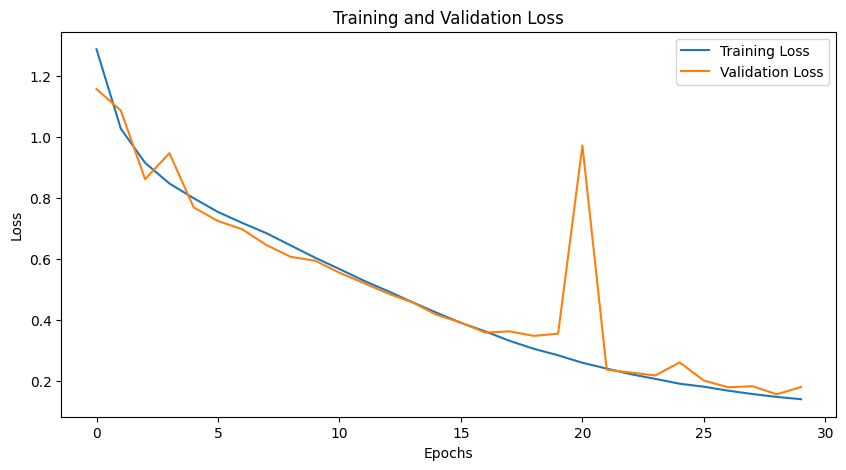

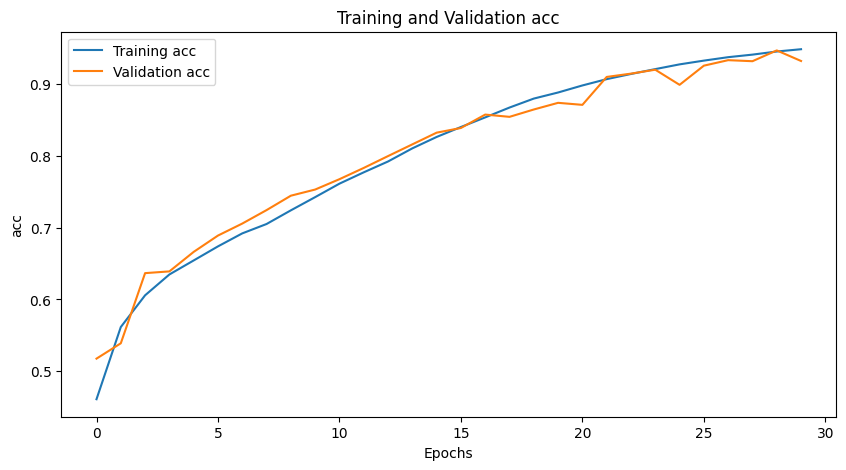

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:57<00:00,  9.32it/s]
test_loss: 0.170  test_accuracy: 93.456


In [28]:
#############################################
# Decide the epochs and learning rate #
#############################################
torch.cuda.empty_cache()
train_from_scratch(Teacher_152, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)
torch.save(Teacher_152.state_dict(), 'utk_teacher_model_152.pth')
T_loss, T_accuracy = test(Teacher_152, test_loader, device=device)

In [31]:
#############################################
# Decide the epochs and learning rate #
#############################################
train_from_scratch(Student, train_loader, val_loader,epochs=30, learning_rate=0.001, device=device)
torch.save(Student.state_dict(), 'utk_student_model.pth')

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:03<00:00, 17.40it/s]
	Training Loss: 1.188583 	Validation Loss: 0.982641
	Train Accuracy: 50.260d% (82466/164080)	Valdation Accuracy: 58.322d% (20506/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [00:59<00:00, 18.61it/s]
	Training Loss: 0.933516 	Validation Loss: 0.862884
	Train Accuracy: 59.916d% (98310/164080)	Valdation Accuracy: 62.955d% (22135/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [00:58<00:00, 18.71it/s]
	Training Loss: 0.828456 	Validation Loss: 0.772740
	Train Accuracy: 64.447d% (105745/164080)	Valdation Accuracy: 66.869d% (23511/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [01:00<00:00, 18.12it/s]
	Training Loss: 0.756949 	Validation Loss: 0.761307
	Train Accuracy: 67.468d% (110702/164080)	Valdation Accu

In [32]:
S_loss, S_accuracy = test(Student, test_loader, device=device)

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [01:03<00:00, 17.37it/s]
test_loss: 0.073  test_accuracy: 97.435


# Response-based distillation

valid epoch[1/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [02:05<00:00,  8.74it/s]
	Training Loss: 7.544900 	Validation Loss: 4.675457
	Train Accuracy: 52.585d% (86282/164080)	Valdation Accuracy: 58.771d% (20664/35160) 
valid epoch[2/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [02:00<00:00,  9.12it/s]
	Training Loss: 4.904363 	Validation Loss: 3.396925
	Train Accuracy: 62.008d% (101742/164080)	Valdation Accuracy: 65.065d% (22877/35160) 
valid epoch[3/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [02:06<00:00,  8.72it/s]
	Training Loss: 4.052280 	Validation Loss: 2.855676
	Train Accuracy: 66.110d% (108473/164080)	Valdation Accuracy: 69.676d% (24498/35160) 
valid epoch[4/30]: 100%|███████████████████████████████████████████████████████████| 1099/1099 [02:01<00:00,  9.03it/s]
	Training Loss: 3.501960 	Validation Loss: 2.638905
	Train Accuracy: 69.264d% (113648/164080)	Valdation Acc

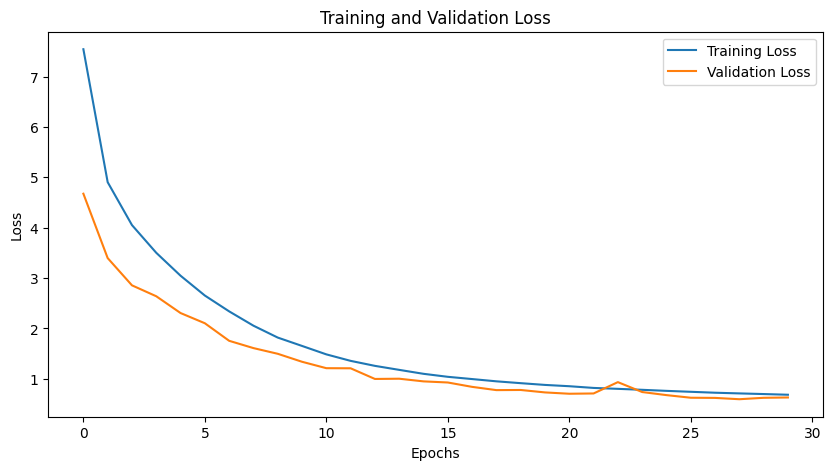

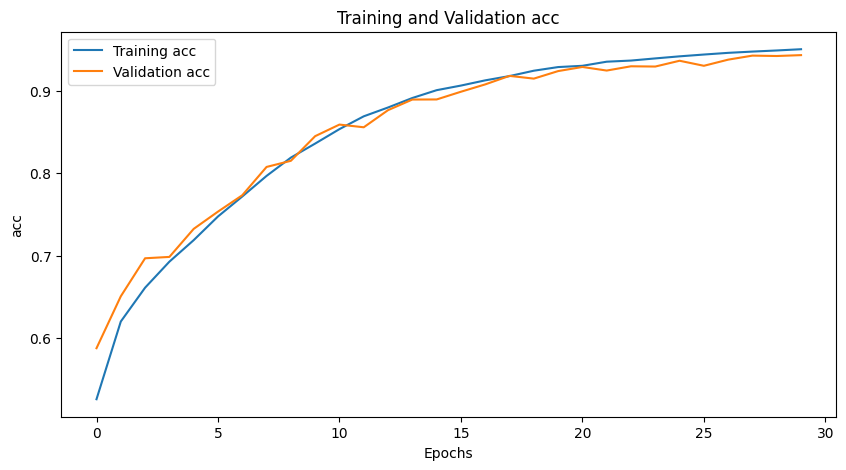

In [32]:
#############################################
# Decide the epochs and learning rate #
#############################################
Student_re = resnet18(num_classes=7)
Student_re = Student_re.to(device)
distiller_re = Distiller(Teacher_152, Student_re, type='response')
train_distillation(distiller_re, Student_re, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)

In [34]:
torch.save(Student_re.state_dict(), '152to18fe_model.pth')

In [35]:
reS_loss, reS_accuracy = test(distiller_re, test_loader, type='distiller', device=device)

test: 100%|████████████████████████████████████████████████████████████████████████| 1099/1099 [02:06<00:00,  8.67it/s]
test_loss: 0.636  test_accuracy: 94.420


# Feature-based distillation

In [37]:
#############################################
# Decide the epochs and learning rate #
#############################################
Student_fe = resnet18(num_classes=7)
Student_fe = Student_fe.to(device)
distiller_fe = Distiller(Teacher_152, Student_fe, type='feature')
train_distillation(distiller_fe, Student_fe, train_loader, val_loader, epochs=30, learning_rate=0.001, device=device)

  0%|                                                                                         | 0/5128 [00:00<?, ?it/s]


C:\Users\NCKU-BAISP\AppData\Local\Temp\ipykernel_33404\2653458035.py:11: UserWarning: Using a target size (torch.Size([32, 256, 55, 55])) that is different to the input size (torch.Size([32, 64, 55, 55])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  layer_loss = criterion(s_feature, t_feature)


RuntimeError: The size of tensor a (64) must match the size of tensor b (256) at non-singleton dimension 1

In [ ]:
ftS_loss, ftS_accuracy = test(distiller_fe, test_loader, type='distiller', device=device)

In [ ]:
torch.save(Student_fe.state_dict(), '152to18re_model.pth')

# Comparison

In [ ]:
print(f'Teacher from scratch: loss-{T_loss}, accuracy-{T_accuracy}')
print(f'Student from scratch: loss-{S_loss}, accuracy-{S_accuracy}')
print(f'Response-based student: loss-{reS_loss}, accuracy-{reS_accuracy}')
print(f'Filter-baswd student: loss-{ftS_loss}, accuracy-{ftS_accuracy}')